<a href="https://colab.research.google.com/github/Aravind-98/Summer_Internship_2020/blob/master/Trial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))   

Saving Price_All.csv to Price_All.csv
User uploaded file "Price_All.csv" with length 1527571 bytes


In [2]:
!pip install pmdarima
!pip install pyramid-arima
!pip install pingouin
!pip install statsmodels

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 2.1MB 16.0MB/s 
     |████████████████████████████████| 8.7MB 24.5MB/s 
  Found existing installation: Cython 0.29.20
    Uninstalling Cython-0.29.20:
      Successfully uninstalled Cython-0.29.20
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 604kB 2.8MB/s 
     |████████████████████████████████| 215kB 2.7MB/s 
  Created wheel for pingouin: filename=pingouin-0.3.5-cp36-none-any.whl size=213104 sha256=0346fa35ce15819afb36862d863aa586636664c4b72469c8b76244d186889d76
  Stored in directory: /root/.cache/pip/wheels/99/03/2f/eb0dcf89fefc479f0a574d98c529e331ac90cbaed11236078a
  Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4962 sha256=9214d1dc3774dd47c750dc6f0134e8978df96e0c14414f6bc92f1976f0e4e26a
  Stored in directory: /root/.cache/pip/whee

In [3]:
# Import all nesecessary libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pingouin as pg
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dropout, SimpleRNN, GRU, Dense, RepeatVector, TimeDistributed
from keras.utils import plot_model
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
import keras
from pmdarima.arima import ndiffs
import pmdarima as pm
import scipy.stats as stats

Using TensorFlow backend.


In [4]:
def load_data(filename):
    df=pd.read_csv(filename)
    df.dropna(inplace=True)
    df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
    df.index = df['Date']
    df=df[df.columns[1:]]
    return df

def rolling_pc(df):
    new_data=[]
    columns=list(df.columns)
    for i in range(int(len(df)/10)-1):
        extract=data[10*i:10*i+10]
        pcorr_vec=[]
        print("~"*5+str(i)+"~"*5)
        for j in range(len(data.columns)-1):
            covar=list(set(columns[:-1]).difference({columns[j]}))
            print("   "+columns[j]+" "+columns[-1])
            p_cor=pg.partial_corr(data=extract, x=columns[j], y=columns[-1], covar=covar, method='pearson').round(3)
            pcorr_vec.append(float(p_cor["r"]))
        new_data.append(pcorr_vec)
    PCor_dataset=pd.DataFrame(np.array(new_data),columns=data.columns[:-1])
    return PCor_dataset


In [5]:
df = load_data("Price_All.csv")
data=df[:480]
pre_ARIMA_data=rolling_pc(data)

~~~~~0~~~~~
   Price_1 Price_51
   Price_2 Price_51
   Price_3 Price_51
   Price_4 Price_51
   Price_5 Price_51
   Price_7 Price_51
   Price_8 Price_51
   Price_9 Price_51
   Price_11 Price_51
   Price_12 Price_51
   Price_14 Price_51
   Price_15 Price_51
   Price_16 Price_51
   Price_17 Price_51
   Price_18 Price_51
   Price_19 Price_51
   Price_20 Price_51
   Price_21 Price_51
   Price_22 Price_51
   Price_23 Price_51
   Price_24 Price_51
   Price_26 Price_51
   Price_27 Price_51
   Price_28 Price_51
   Price_29 Price_51
   Price_30 Price_51
   Price_31 Price_51
   Price_32 Price_51
   Price_33 Price_51
   Price_34 Price_51
   Price_35 Price_51
   Price_36 Price_51
   Price_37 Price_51
   Price_38 Price_51
   Price_39 Price_51
   Price_40 Price_51
   Price_41 Price_51
   Price_42 Price_51
   Price_43 Price_51
   Price_44 Price_51
   Price_45 Price_51
   Price_46 Price_51
   Price_47 Price_51
   Price_48 Price_51
   Price_49 Price_51
   Price_50 Price_51
~~~~~1~~~~~
   Price_1 Price_5

In [6]:
pre_ARIMA_data.describe()

,Price_1,Price_2,Price_3,Price_4,Price_5,Price_7,Price_8,Price_9,Price_11,Price_12,Price_14,Price_15,Price_16,Price_17,Price_18,Price_19,Price_20,Price_21,Price_22,Price_23,Price_24,Price_26,Price_27,Price_28,Price_29,Price_30,Price_31,Price_32,Price_33,Price_34,Price_35,Price_36,Price_37,Price_38,Price_39,Price_40,Price_41,Price_42,Price_43,Price_44,Price_45,Price_46,Price_47,Price_48,Price_49,Price_50
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.00000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,0.275277,0.203319,0.070340,0.175532,0.337021,0.112298,-0.009532,0.343234,0.154702,0.226681,0.256957,0.168340,0.222511,0.134489,0.442362,0.293979,0.356809,0.013128,0.201000,0.329723,0.465021,0.095851,0.297681,0.344128,0.310596,0.454362,0.466915,0.073085,0.34583,0.202191,0.326298,0.339766,0.203234,0.495404,0.492447,0.142128,0.342149,0.396936,0.482723,0.272596,0.280362,0.267830,0.312596,0.370383,0.350894,0.243830
std,0.452083,0.542377,0.566271,0.496856,0.499617,0.518779,0.488518,0.384130,0.479407,0.529404,0.439199,0.549299,0.535683,0.535295,0.464428,0.463111,0.479478,0.522999,0.453904,0.472271,0.456465,0.461797,0.550329,0.546067,0.465041,0.410537,0.437611,0.517367,0.43807,0.501226,0.428229,0.442815,0.519485,0.449389,0.412127,0.469402,0.450977,0.440729,0.432750,0.404927,0.415386,0.440244,0.468057,0.434521,0.474610,0.500662
min,-0.791000,-0.994000,-0.851000,-0.964000,-0.552000,-0.989000,-0.873000,-0.565000,-0.806000,-0.744000,-0.657000,-0.983000,-0.901000,-0.899000,-0.742000,-0.758000,-0.743000,-0.966000,-0.688000,-0.764000,-0.684000,-0.874000,-0.812000,-0.784000,-0.642000,-0.574000,-0.709000,-0.871000,-0.58300,-0.940000,-0.918000,-0.810000,-0.932000,-0.652000,-0.571000,-0.631000,-0.709000,-0.834000,-0.883000,-0.545000,-0.640000,-0.943000,-0.897000,-0.803000,-0.726000,-0.784000
25%,0.018500,-0.035000,-0.488500,-0.152000,-0.169500,-0.152000,-0.358500,0.124500,-0.175500,-0.257000,-0.026000,-0.190000,-0.208500,-0.261500,0.123500,-0.017000,0.101000,-0.353000,-0.202000,0.056000,0.206500,-0.250000,-0.049500,-0.147500,0.002000,0.191000,0.194500,-0.325000,-0.05100,-0.233000,-0.016500,-0.002500,-0.089000,0.178500,0.341000,-0.314500,-0.022500,0.171000,0.285000,-0.116000,-0.007500,-0.021000,0.056500,0.077500,0.067000,-0.178500
50%,0.306000,0.268000,0.057000,0.208000,0.444000,0.102000,-0.033000,0.393000,0.249000,0.326000,0.286000,0.232000,0.360000,0.155000,0.594000,0.376000,0.421000,-0.059000,0.316000,0.387000,0.597000,0.063000,0.468000,0.560000,0.376000,0.569000,0.659000,0.106000,0.42700,0.212000,0.342000,0.496000,0.258000,0.685000,0.589000,0.236000,0.477000,0.477000,0.555000,0.390000,0.267000,0.190000,0.343000,0.413000,0.479000,0.362000
75%,0.669000,0.628000,0.625000,0.644500,0.754000,0.535000,0.362500,0.639000,0.570000,0.671500,0.619000,0.617000,0.693000,0.557000,0.777500,0.663000,0.735000,0.420500,0.562500,0.737000,0.824500,0.452500,0.740000,0.805500,0.724500,0.780500,0.792000,0.501500,0.74500,0.642500,0.685500,0.677500,0.631000,0.841500,0.800000,0.553500,0.724500,0.737000,0.802000,0.578500,0.609000,0.550000,0.716000,0.712000,0.741500,0.708500
max,0.955000,0.952000,0.967000,0.881000,0.988000,0.881000,0.911000,0.949000,0.918000,0.973000,0.955000,0.965000,0.963000,0.973000,0.973000,0.902000,0.986000,0.947000,0.945000,0.946000,0.973000,0.980000,0.987000,0.993000,0.973000,0.976000,0.978000,0.896000,0.95100,0.956000,0.949000,0.930000,0.918000,0.975000,0.971000,0.937000,0.950000,0.966000,0.976000,0.886000,0.970000,0.958000,0.977000,0.962000,0.985000,0.949000


In [7]:
def get_residuals(df,in_sample=True):
    forecast=[]
    residuals=[]
    for i in range(len(df.columns)):
        data=df[df.columns[i]]
        kpss_diffs = ndiffs(data, alpha=0.01, test='kpss', max_d=2)
        adf_diffs = ndiffs(data, alpha=0.01, test='adf', max_d=2)
        n_diffs = max(adf_diffs, kpss_diffs)

        #print(f"Estimated differencing term: {n_diffs}")
        model = pm.auto_arima(data, d=n_diffs, seasonal=False, stepwise=True, suppress_warnings=True, error_action="ignore", max_p=6, max_order=None, trace=False)
        #print(f"{df.columns[i]}   :::::   ARIMA model order:{model.order}")
        pred = list(model.predict_in_sample())
        resid=list(data-pred)
        residuals.append(resid) 
        if in_sample==False:
            fcast=model.predict(1)
            forecast.append(fcast) 
    Residuals=pd.DataFrame(np.around(np.array(residuals).T,3),columns=df.columns) 
    return Residuals,forecast   

In [8]:
def train_dev_split(pre_ARIMA_data, window_size, split_ratio=0.5):
    D=[]
    for i in range(len(pre_ARIMA_data.index)-window_size):
        #could probably store just arrays
        d=pd.DataFrame(np.array(pre_ARIMA_data.iloc[i:i+window_size+1].copy()),columns=pre_ARIMA_data.columns)
        r,_=get_residuals(d)
        D.append(r)
        print(f"   ~~ Iteration:{i+1} ~~")

    X={}
    y={}
    u=[]
    v=[]
    for i in range(len(D)):
        u.append(np.array(D[i].iloc[:-1].copy()))
        v.append(np.array(D[i].iloc[-1].copy()))
    X_arr=np.array(u)
    y_arr=np.array(v)  

    s=int(split_ratio*X_arr.shape[0])

    X["train"]=X_arr[:s,:,:]
    X["dev"]=X_arr[s:,:,:]
    y["train"]=y_arr[:s,:]  
    y["dev"]=y_arr[s:,:]


    test=pd.DataFrame(np.array(pre_ARIMA_data.iloc[-window_size:].copy()),columns=pre_ARIMA_data.columns)
    X["test"],forecast=get_residuals(test,False)
    X["test"]=np.expand_dims(X["test"],axis=0)
    ARIMA_forecast=np.reshape(np.array(forecast),(-1,))
    y["ARIMA forecast"]=ARIMA_forecast

    print(f"X's shape:{X_arr.shape}   y's shape:{y_arr.shape}") 
    #print(X["train"].shape y["train"].shape})
    #print(f"X dev's shape:{X["dev"].shape}   y dev's shape:{y["dev"].shape}")
    return X,y

In [9]:
X,y=train_dev_split(pre_ARIMA_data, 10, split_ratio=0.8)

   ~~ Iteration:1 ~~
   ~~ Iteration:2 ~~
   ~~ Iteration:3 ~~
   ~~ Iteration:4 ~~
   ~~ Iteration:5 ~~
   ~~ Iteration:6 ~~
   ~~ Iteration:7 ~~
   ~~ Iteration:8 ~~
   ~~ Iteration:9 ~~
   ~~ Iteration:10 ~~
   ~~ Iteration:11 ~~
   ~~ Iteration:12 ~~
   ~~ Iteration:13 ~~
   ~~ Iteration:14 ~~
   ~~ Iteration:15 ~~
   ~~ Iteration:16 ~~
   ~~ Iteration:17 ~~
   ~~ Iteration:18 ~~
   ~~ Iteration:19 ~~
   ~~ Iteration:20 ~~
   ~~ Iteration:21 ~~
   ~~ Iteration:22 ~~
   ~~ Iteration:23 ~~
   ~~ Iteration:24 ~~
   ~~ Iteration:25 ~~
   ~~ Iteration:26 ~~
   ~~ Iteration:27 ~~
   ~~ Iteration:28 ~~
   ~~ Iteration:29 ~~
   ~~ Iteration:30 ~~
   ~~ Iteration:31 ~~
   ~~ Iteration:32 ~~
   ~~ Iteration:33 ~~
   ~~ Iteration:34 ~~
   ~~ Iteration:35 ~~
   ~~ Iteration:36 ~~
   ~~ Iteration:37 ~~
X's shape:(37, 10, 46)   y's shape:(37, 46)


In [21]:
def plot_residual_distribution(X_train):
    plt.figure(figsize=(10,7))
    train_melt=sorted(np.ravel(X_train))
    fit = stats.norm.pdf(train_melt, np.mean(train_melt), np.std(train_melt))
    plt.hist(train_melt, density=True,color='grey', bins=np.arange(-4,5,0.1))#[-4,-3,-2,-1,0,1,2,3,4,5])
    plt.plot(train_melt,fit,color='blue')
    plt.title('residual value distribution')
    plt.xlabel('residual')
    plt.show()
    plt.close()

In [15]:
X["train"].shape

(29, 10, 46)

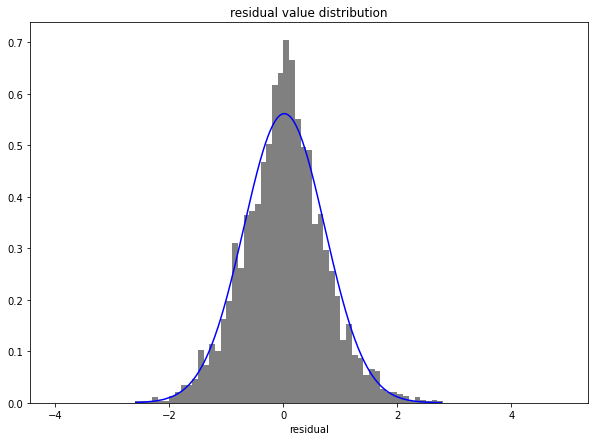

In [23]:
plot_residual_distribution(X["dev"])

In [ ]:
n_steps=X["train"].shape[1]
n_features=X["train"].shape[2]

model=Sequential()
model.add(SimpleRNN(100,activation='relu',return_sequences=True,recurrent_dropout=0.4,input_shape=(n_steps, n_features)))
model.add(TimeDistributed(Dropout(0.3)))
model.add(LSTM(n_features,activation="tanh"))
#model.add(tf.keras.layers.Lambda(lambda x: x * 2))
#model.add(Dense(n_features,activation="tanh"))
model.compile(optimizer='adam', loss="mse", metrics=["mse"])
history=model.fit(X["train"], y["train"], epochs=200, batch_size=3,verbose=1,validation_data=(X["dev"],y["dev"]))
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss))
plt.figure(figsize=(15,7))
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["val_loss", "Loss"])


In [52]:
X_train,y_train,X_dev,y_dev=X["train"],y["train"],X["dev"],y["dev"]

X_train=np.reshape(X_train,(-1,X_train.shape[1],1))
X_dev=np.reshape(X_dev,(-1,X_dev.shape[1],1))
y_train=np.reshape(y_train,(-1,))
y_dev=np.reshape(y_dev,(-1,))

print(y_train.shape)

(1334,)


Train on 1334 samples, validate on 368 samples
Epoch 1/100
1334/1334 [==============================] - 1s 703us/step - loss: 0.5014 - val_loss: 0.2826
Epoch 2/100
1334/1334 [==============================] - 1s 509us/step - loss: 0.2679 - val_loss: 0.2826
Epoch 3/100
1334/1334 [==============================] - 1s 508us/step - loss: 0.2523 - val_loss: 0.2826
Epoch 4/100
1334/1334 [==============================] - 1s 599us/step - loss: 0.2512 - val_loss: 0.2826
Epoch 5/100
1334/1334 [==============================] - 1s 537us/step - loss: 0.2533 - val_loss: 0.2826
Epoch 6/100
1334/1334 [==============================] - 1s 527us/step - loss: 0.2517 - val_loss: 0.2826
Epoch 7/100
1334/1334 [==============================] - 1s 515us/step - loss: 0.2684 - val_loss: 0.2826
Epoch 8/100
1334/1334 [==============================] - 1s 554us/step - loss: 0.2514 - val_loss: 0.2826
Epoch 9/100
1334/1334 [==============================] - 1s 584us/step - loss: 0.2506 - val_loss: 0.2826
Epoch 10

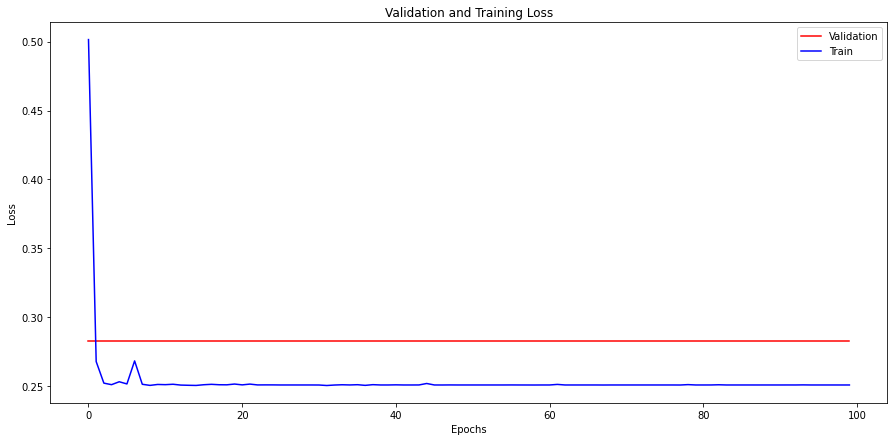

In [59]:
n_steps=X_train.shape[1]
n_features=1

model=Sequential()
model.add(SimpleRNN(30,activation="relu",recurrent_dropout=0.6,input_shape=(n_steps, n_features)))
#model.add(TimeDistributed(Dropout(0.4)))
model.add(Dropout(0.5))
model.add(Dense(1,activation="relu"))
model.compile(optimizer="rmsprop",loss="mse")

history=model.fit(X_train,y_train,epochs=100,batch_size=5,validation_data=(X_dev,y_dev))

val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss))
plt.figure(figsize=(15,7))
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('Validation and Training Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Validation", "Train"])


In [ ]:
'''
data_matrix = []

for i in range(len(new_assets)):
    for j in range(len(new_assets)-1-i):
        a = new_assets[i]
        b = new_assets[9-j]
        corr_series = rolling_corr(a,b)[99:]
        corr_strided = list(corr_series[[100*k for k in range(24)]])
        data_matrix.append(corr_strided)

data_dictionary = {}
for i in range(len(data_matrix)):
    data_dictionary[str(i)] = data_matrix[i]
data_df = pd.DataFrame(data_dictionary)

before_arima_dataset = []
for i in range(45):
    before_arima_dataset.append(data_df[str(i)][:21])
    before_arima_dataset.append(data_df[str(i)][1:22])
    before_arima_dataset.append(data_df[str(i)][2:23])
    before_arima_dataset.append(data_df[str(i)][3:])
before_arima_dataset = pd.DataFrame(np.array(before_arima_dataset))
before_arima_dataset.shape
#before_arima_dataset
#before_arima_dataset.to_csv('C:/Users/Froilan/Desktop/myFiles/JupyterFiles/stock_correlation_prediction/train_dev_test/new_asset_before_arima.csv')
'''

In [ ]:
'''
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

train=PCor_dataset[:48]
#train = np.transpose(train.loc[:, ~train.columns.str.contains('^Unnamed')])
for _ in range(5):
    
    randint = random.randrange(0,46,1)
    print(columns[randint])
    train[columns[randint]].plot()
    plt.show()
    plt.close()
    plot_acf(train[columns[randint]])
    plt.show()
    plt.close()
    plot_pacf(train[columns[randint]])
    plt.show()
    plt.close()
    print('----------------------------------------------------')
'''    

In [ ]:
test=pd.DataFrame(np.array(pre_ARIMA_data.iloc[-window_size:].copy()),columns=pre_ARIMA_data.columns)
forecast=[]
residuals=[]
for i in range(len(test.columns)):
        data=test[test.columns[i]]
        kpss_diffs = ndiffs(data, alpha=0.01, test='kpss', max_d=2)
        adf_diffs = ndiffs(data, alpha=0.01, test='adf', max_d=2)
        n_diffs = max(adf_diffs, kpss_diffs)

        #print(f"Estimated differencing term: {n_diffs}")
        model = pm.auto_arima(data, d=n_diffs, seasonal=False, stepwise=True, suppress_warnings=True, information_criterion='aic', error_action="ignore", max_p=6, max_order=None, trace=False)
        print(f"{df.columns[i]}   :::::   ARIMA model order:{model.order}")
        pred = list(model.predict_in_sample())
        fcast=model.predict(1)
        forecast.append(fcast)
        resid=list(data-pred)
        residuals.append(resid)
Residuals=pd.DataFrame(np.around(np.array(residuals).T,3),columns=test.columns)
X_test=Residuals
ARIMA_forecast=np.reshape(np.array(forecast),(-1,))
plt.plot(forecast)